In [1]:
import pandas as pd
import string
import re
import nltk
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
pd.set_option('display.max_colwidth',100)

df = pd.read_csv(r"C:\Users\Acer\Desktop\Rishi\JIO Internship\lynda learning\exercise files\Ex_Files_NLP_Python_ML_EssT\Exercise Files\Ch01\01_09\Start\SMSSpamCollection.tsv", sep="\t")
df.columns = ["label", "message"]
df.head(3)

label  \
0  spam   
1   ham   
2   ham   

                                                                                               message  
0  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...  
1                                        Nah I don't think he goes to usf, he lives around here though  
2                        Even my brother is not like to speak with me. They treat me like aids patent.

In [4]:
df["Message Length"] = df["message"].apply(lambda x: len(x) - x.count(" "))

In [5]:
def count_digit(text):
    count = sum([1 for char in text if char in "1234567890"])
    return(round(count/(len(text) - text.count(" ")),4)*100)

df["Digit %"] = df["message"].apply(lambda x: count_digit(x))
df.head(3)

label  \
0  spam   
1   ham   
2   ham   

                                                                                               message  \
0  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...   
1                                        Nah I don't think he goes to usf, he lives around here though   
2                        Even my brother is not like to speak with me. They treat me like aids patent.   

   Message Length  Digit %  
0             128    19.53  
1              49     0.00  
2              62     0.00

In [6]:
def clean_text(text):
    punctuation_less_text = "".join([char.lower() for char in text if char not in string.punctuation])
    tokens= re.split('\W+', punctuation_less_text)
    stopword_less_tokens = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return(stopword_less_tokens)

In [7]:
tf_idf_vec = TfidfVectorizer(analyzer=clean_text)
X_tf_idf = tf_idf_vec.fit_transform(df["message"])
print(X_tf_idf.shape)

(5567, 8911)


In [8]:
vectorised_df = pd.DataFrame(X_tf_idf.toarray())
vectorised_df.columns = tf_idf_vec.get_feature_names()
X_features_df = pd.concat([df["Message Length"],df["Digit %"],vectorised_df], axis = 1)
X_features_df.head(5)

Message Length  Digit %         0  008704050406  0089my  0121  01223585236  \
0             128    19.53  0.0  0.0           0.0     0.0   0.0          0.0   
1              49     0.00  0.0  0.0           0.0     0.0   0.0          0.0   
2              62     0.00  0.0  0.0           0.0     0.0   0.0          0.0   
3              28     0.00  0.0  0.0           0.0     0.0   0.0          0.0   
4             135     0.74  0.0  0.0           0.0     0.0   0.0          0.0   

   01223585334  0125698789 ...   zindgi  zoe  zogtorius  zoom  zouk  zyada  \
0          0.0         0.0 ...      0.0  0.0        0.0   0.0   0.0    0.0   
1          0.0         0.0 ...      0.0  0.0        0.0   0.0   0.0    0.0   
2          0.0         0.0 ...      0.0  0.0        0.0   0.0   0.0    0.0   
3          0.0         0.0 ...      0.0  0.0        0.0   0.0   0.0    0.0   
4          0.0         0.0 ...      0.0  0.0        0.0   0.0   0.0    0.0   

     é    ü  üll  〨ud  
0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  

[5 rows x 8913 columns]

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
print(RandomForestClassifier())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [11]:
from sklearn.model_selection import KFold, cross_val_score

In [25]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

In [26]:
X_train,X_test,Y_train,Y_test = train_test_split(X_features_df,df["label"],test_size = 0.25,random_state = 1)

In [27]:
rf_definition = RandomForestClassifier(n_estimators=50,max_depth = 60,n_jobs = -1)
rf_model = rf_definition.fit(X_train,Y_train)

In [28]:
important_features = sorted(zip(rf_model.feature_importances_,X_train.columns),reverse = True)
important_features[0:15]

[(0.12422800576305876, 'Digit %'),
 (0.04618826147060809, 'Message Length'),
 (0.035686929144516426, 'call'),
 (0.030100765668426833, 'mobile'),
 (0.02095958681693068, 'free'),
 (0.020712302594880327, 'claim'),
 (0.015552593141445976, 'service'),
 (0.015348658742225447, 'txt'),
 (0.013367826385969032, 'prize'),
 (0.011935848637747099, 'text'),
 (0.011935447181322598, 'stop'),
 (0.007907277612102753, '1000'),
 (0.00788972014963052, 'per'),
 (0.007501978356527871, 'tone'),
 (0.007445019183651147, 'reply')]

In [29]:
Y_predictions = rf_model.predict(X_test)
precision,recall,fscore,support = score(Y_test,Y_predictions,pos_label = "spam",average = "binary")

In [30]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, Y_predictions)

In [31]:
print(" Precision of model is {}\n Recall of model is {}\n Accuracy of model is {}\n F1 score of model is {}".format(round(precision,4),
                                                                                                                    round(recall,4),
                                                                                                                    round(accuracy,4),
                                                                                                                    round(fscore,4)))

 Precision of model is 1.0
 Recall of model is 0.901
 Accuracy of model is 0.9864
 F1 score of model is 0.9479


In [32]:
# precision tells that 100% of messages detected as spam by system were actually spam

In [33]:
# recall tells that 90.1% of spam messages were detected and 9.90% spam messages were not detected

In [34]:
#accuracy tells that out of every 100 encountered messages 99 were correctly classified as spam or ham

In [35]:
df_weights = pd.DataFrame(important_features[0:25])
df_weights.columns = ["Word Weight","Word"]
df_weights.to_csv('Spam_words.csv', header=False, index=False, sep='\t', mode='a')

In [36]:
# plotting values 

In [37]:
spam_true = 0
spam_predicted = 0
for label in Y_test:
    if label == "spam":
        spam_true += 1
        
for label in Y_predictions:
    if label == "spam":
        spam_predicted += 1
        
print("true spam : {}".format(spam_true))
print("detected spam : {}".format(spam_predicted))

true spam : 192
detected spam : 173


In [38]:
ham_true = 0
ham_predicted = 0
for label in Y_test:
    if label == "ham":
        ham_true += 1
        
for label in Y_predictions:
    if label == "ham":
        ham_predicted += 1
        
print("true ham : {}".format(ham_true))
print("detected ham : {}".format(ham_predicted))

true ham : 1200
detected ham : 1219


In [46]:
import matplotlib.pyplot as plt
import numpy as np

In [47]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,10

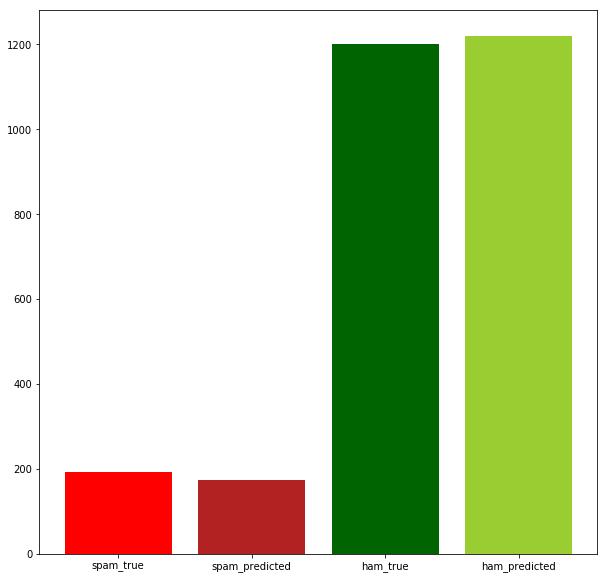

In [98]:
y = [spam_true,spam_predicted,ham_true,ham_predicted]
x = np.arange(len(y))
plt.bar(x,y,color =["red","firebrick","darkgreen","yellowgreen"])
plt.xticks(ticks =[])
plt.xticks(np.arange(4),("spam_true","spam_predicted","ham_true","ham_predicted"))
plt.savefig('Spam_detection.jpeg')